# Uniti Assignment - install probability prediction

Goal: Predict install probability for add install event given a set of features. 

## Task description

The data is a sample from our production environment. Each row refers to an impression (start of a video ad belonging to the specific campaign), and includes input features and an install label indicating whether the impression resulted in the install of the advertised game or not.

Input features and install label are provided for the training data (trainingData.csv). The test data (testData.csv) includes only the input features. Your task is to predict install probability for all the available impressions in the test data.

Return: 
1. Predicted install probability for each impression Id in the test data.
2. Source code for your solution. Feel free to select language/tools that you see appropriate.
3. A report in which you explain/justify your choices and analyze your solution.

Notice: There is no one single correct solution. You may also provide ideas how you would continue after your proposed solution.

Field descriptions:

id:                       impression id
timestamp:                time of the event in UTC.
campaignId:               the campaign id of the advertising campaign
platform:                 user's platform
softwareVersion:          software version of the device
sourceGameId:             the game id of the publishing game
country:                  the country of the user
startCount:               how many times the user has ever started a campaign ever
viewCount:                how many times the user has ever viewed a campaign ever
clickCount:               how many times the user has ever clicked a campaign ever
installCount:             how many times the user has installed games from this network ever
lastStart:                the time of users last start event (any campaign)
startCount1d:             how many times user has started (any) campaigns within the last 24h
startCount7d:             how many times user has started (any) campaigns within the last 7 days
connectionType:           internet connection type
deviceType:               device model
install:                  binary indicator whether install was observed (install=1) or was not observed (install=0) after impression


## The data

<a id='TL;DR'></a>
<div class=" alert alert-warning">
    <b>tl;dr.</b> 

  <li>The ultimate task is to recommend ads but the problem statement is not acknowledging this. Rather than modelling $p(y|x)$, where $y$ is the install event and $x$ contains the features and the action $a=$campaignId, it would be more suitable to model $p(y|x,a)$ from the data. </li>
  <li>To create a representation for the action, we could have exploited the user interactions with the advertised ads by creating user ID vs campain ID matrix and use a function (e.g., latent factorization) of it for action representation, but the user ID is missing from the data. </li>
  <li>User ID (history of campains recommended) is missing from the data but potentially important. I guess you have this as you compute features such as installCount.</li>
  <li>I am removing the two time features and creating a new one experssing the difference between those two in minutes (also added suggestions for other ways to exploit the time features).</li>
  <li></li>

</div>
 

The following block loads the training data and prints some primitive statistics. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
tr_filename = "training_data.csv"
# load the whole training data (no need to chunk it!)
tr_data = pd.read_csv(tr_filename, sep=';')
# print basic statistics about the data
print(tr_data.info())
Y = tr_data['install']
print("Number of installs: {},".format(Y.sum()))
print("Percentage of installs: {:f},".format((Y.sum()/Y.shape[0])))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206990 entries, 0 to 2206989
Data columns (total 17 columns):
id                 object
timestamp          object
campaignId         object
platform           object
softwareVersion    object
sourceGameId       int64
country            object
startCount         int64
viewCount          int64
clickCount         int64
installCount       int64
lastStart          object
startCount1d       int64
startCount7d       int64
connectionType     object
deviceType         object
install            int64
dtypes: int64(8), object(9)
memory usage: 286.2+ MB
None
Number of installs: 26497,
Percentage of installs: 0.012006,


The training data contains $n=2206990$ instances with $d=16$ features and the corresponding responses $y \in \{0,1\}$  indicates whether install was observed (install=1) or was not observed (install=0) after impression. The data set is very unbalanced as the occurance of an install event is only $\%1.2$.

Let's print the first five rows of the dataset.

In [3]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None, 'display.width', 100):
    print(tr_data.head())

                         id                      timestamp                campaignId platform  \
0  5c36658fb58fad351175f0b6  2019-01-09T21:20:15.943+00:00  59687f0d896a6b0e5ce6ea15      ios   
1  5c38d5ab1c16172870186b5a  2019-01-11T17:43:07.609+00:00  59687f0d896a6b0e5ce6ea15      ios   
2  5c38815de8f4e50e256e4f9c  2019-01-11T11:43:25.168+00:00  59687f0d896a6b0e5ce6ea15      ios   
3  5c409ace532d5806d2c6a5e6  2019-01-17T15:10:06.420+00:00  59687f0d896a6b0e5ce6ea15      ios   
4  5c3904b92d798c41e7f3088a  2019-01-11T21:03:53.145+00:00  59687f0d896a6b0e5ce6ea15      ios   

  softwareVersion  sourceGameId country  startCount  viewCount  clickCount  installCount  \
0          11.4.1       1373094      US          25         24           0             2   
1            12.1       2739989      US          10          9           2             0   
2          12.1.2       1373094      US          27         26           0             0   
3          12.1.2       1217749      US          

Let's look at the null values in the data. 

In [4]:
## check for duplicated data rows --> no need. IDs are all unique
#print("There are {} duplicated rows ".format(tr_data.duplicated().sum()))

print("Number of nulls per feature:")
print(tr_data.isnull().sum())

print("number of installs in country nulls: {}".format(Y[tr_data['country'].isnull()].sum()))
print("number of installs in lastStart nulls: {}".format(Y[tr_data['lastStart'].isnull()].sum()))

Number of nulls per feature:
id                      0
timestamp               0
campaignId              0
platform                0
softwareVersion         0
sourceGameId            0
country               101
startCount              0
viewCount               0
clickCount              0
installCount            0
lastStart          163180
startCount1d            0
startCount7d            0
connectionType          0
deviceType              0
install                 0
dtype: int64
number of installs in country nulls: 1
number of installs in lastStart nulls: 2821


A quick way to handle the null values is to just discard the corresponding rows from the dataset. However, lastStart feature has a huge number of nulls where 2821 of those rows have install event (around 10 percent of the total rows with install event), therefore it is better to handle them in another way. We will take care of these in the next sections where we look deeper at individual features.

Let's look at the features one by one

In [5]:
for name in tr_data.columns:
    print(name)
    print(tr_data[name].describe(), "\n")

id
count                      2206990
unique                     2206990
top       5c36d2e6c434145feca1fcdd
freq                             1
Name: id, dtype: object 

timestamp
count                           2206990
unique                          2204923
top       2019-01-10T12:14:36.205+00:00
freq                                  3
Name: timestamp, dtype: object 

campaignId
count                      2206990
unique                        5704
top       5c3bfb0b36c2c6cc18710e7b
freq                         41740
Name: campaignId, dtype: object 

platform
count     2206990
unique          2
top       android
freq      1591868
Name: platform, dtype: object 

softwareVersion
count     2206990
unique        174
top         8.0.0
freq       360593
Name: softwareVersion, dtype: object 

sourceGameId
count    2.206990e+06
mean     3.085592e+06
std      1.376251e+07
min      1.105500e+04
25%      1.202538e+06
50%      1.631784e+06
75%      2.639966e+06
max      1.316274e+08
Name: sourceGa

### *id*: 
* Indicates the impression ID. 
* All ID's are unique. 
* This feature will be discarded.

In [6]:
# remove "id" column and save the data in a new variable
tr_data_m = tr_data.drop(columns="id")

### *timestamp* and *lastStart*:   
* **timestamp**: time of the event in UTC.
* **LastStart**: the time of users last start event (any campaign) (I assume in UTC).
* These are the two time features in the data. Potentially can be useful as:
* 1) their interaction might have an influence on the response variable. 
* 2) user's behaviour may depend on the time of the day (e.g., people might be more likely to instal an app in the evenning or over the weekend than working hours(?)). To test this, we also need to convert the UTC time zone to a local time zone using data in the "country" feature and also add new features such as "weekend" to the data.  
* For now I only consider the first point due to my personal time constrains. 
* In the following code box, first I will also replace the nan values in 'lastStart' with the corresponding values in 'timestamp' and then I will define a new feature ('epoch_diff') as the difference in minutes between the 'timestamp' and 'lastStart', and drop the old features. 

In [7]:
# replace nan values in 'lastStart' with values in 'timestamp'
nan_idx = tr_data['lastStart'].isnull()
tr_data_m['lastStart'].loc[nan_idx] = tr_data_m['timestamp'][nan_idx]

# convert the string objects to datetime
tr_data_m['timestamp'] = pd.to_datetime(tr_data_m['timestamp'],infer_datetime_format=True)
tr_data_m['lastStart'] = pd.to_datetime(tr_data_m['lastStart'],infer_datetime_format=True)

# convert times to epoch in minutes
epoch_timestamp = pd.to_datetime(tr_data_m['timestamp']).astype(np.int64) // (10**9 * 60)
epoch_lastStart = pd.to_datetime(tr_data_m['lastStart']).astype(np.int64) // (10**9 * 60)

# create a new feature of difference in timestamp and lastStart in minutes
tr_data_m['epoch_diff'] = epoch_timestamp - epoch_lastStart

#print(tr_data_m['timestamp'][:10])
#print(tr_data_m['lastStart'][:10])
#print(tr_data_m['epoch_diff'][:10])

# remove "timestamp" column
tr_data_m = tr_data_m.drop(columns="timestamp")
tr_data_m = tr_data_m.drop(columns="lastStart")

C:\Users\Pedram\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### *campaignId*: 
* The campaign id of the advertising campaign. 
* I guess this is all we have about the recommended ads. 
* There are 5704 unique campaigns.
* The dataset is biased based on this feature, as I guess the campainId is selected by an intellligent algorithm.
* The following code box looks at the distribution of campains over number of appearances and number of installs.

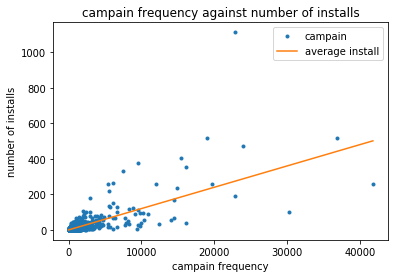

In [8]:
# compute campain frequencies
campainId_counts = tr_data_m['campaignId'].value_counts()
#find the number of installs for each campainId
install_1_frame = tr_data_m[tr_data_m['install'] == 1]
install_per_campain = np.zeros(campainId_counts.shape[0])
for i in range(campainId_counts.shape[0]):  
    install_per_campain[i] = sum(install_1_frame['campaignId'] == campainId_counts.index[i])

# plot campain frequencies against number of installs
plt.figure()
plt.plot(campainId_counts,install_per_campain,'.', label='campain')
plt.plot([0,campainId_counts[0]],[0,campainId_counts[0]*(Y.sum()/Y.shape[0])], label='average install')
plt.legend()
plt.title("campain frequency against number of installs")
plt.xlabel("campain frequency")
plt.ylabel("number of installs")

# plot install ratio for frequent campains
#install_ratio = install_per_campain/campainId_counts
#plt.figure()
#plt.plot(range(1000),100*install_ratio[:1000],'.')
#plt.title("Install ratio of popular campains (more than {} appearance)".format(campainId_counts[100]))
#plt.xlabel("frequent campains (sorted)")
#plt.ylabel("install ratio")

plt.show()

#print(campainId_counts)
#print(install_per_campain)
#print(install_ratio)

* There figure shows three things: 1) the expected correlation between number of installs and number of recommendation of the campains 2) huge number of campains have only been recommended very few times 3) A bit concerning point that there are a few extremely frequent recommended campains that have lower than average install ratio, while some better than average campains that are not recommended that frequently. (just a visualization, no big conclusion here).
* We need to find a good representation for campains (see next box)

<a id='What I would have done..'></a>
<div class=" alert alert-warning">
    <b>What I would have done...</b> 

<br />
It would be crucially important for the core reommendation task to have a feature representation for campains. Unfortunately, it seems that Unity does not have these information. I can think of two ways to do this: (i) try to generate features from the campain itself (e.g., from the textual description of the campain or the video).(ii) generate features for campain based on the interaction data (e.g., if two users installed a couple of similiar campains, then the information about one user can be generalized to the other one for the recommendation). It seems that approach (i) has not been successful. However, it should be possible to exploit the interaction data in (ii). For this, I would need to have a unique user ID to be able to create the sparse matrix of campaignId vs. user_id, where the elements indicate install or no-install event. I could then use matrix factorization and try to estimate this big matrix with two simpler matrix (e.g., AV), and learn these simpler (low dimensional) matrices by minimizing the reconstruction error. I would then be able to use rows of A as a feature representation for campains.   
</div>

* As for now, I just represent each campain with its frequency. Please note that this is not a good (or stable) approach since as the designer of the recommender system, we are also controlling the frequency of campain observations. Anyway, this would be hack for now (but not that optimal as we are losing a lot of information). Next code block creates this new feature.

In [9]:
# first conver the campainId_counts to a dict
campainId_dict = campainId_counts.to_dict()

campain_freq = np.zeros(tr_data_m.shape[0])
for i in range(tr_data_m.shape[0]):
    campain_freq[i] = campainId_dict[tr_data_m['campaignId'][i]]

# add the new feature to the data frame
tr_data_m.insert(1, 'campain_freq', campain_freq)

# remove 'campaignId' column
tr_data_m = tr_data_m.drop(columns="campaignId")

### *platform*: 
* User's platform (two options: android and ios)
* The following box convert this to binary feature.

In [10]:
# convert platform to binary values (1:ios, 0:android)
print(tr_data_m['platform'].value_counts())
tr_data_m['platform'] = tr_data_m['platform'] == 'ios' 
tr_data_m['platform'] = tr_data_m['platform'].astype(np.int64)

android    1591868
ios         615122
Name: platform, dtype: int64


### *softwareVersion*: 
* Software version of the device.
* There are 174 different software versions.  
* To simplify this feature, we extract the first number in the 'softwareVersion' string and consider it as the representative of the software version. The following code block builds this new feature 'softwareVersion_num' and drops 'softwareVersion' column.

In [11]:
# the following simple function finds the first number in an string
def find_first_num(input_str):
    for i, c in enumerate(input_str):
        if c.isdigit():
            start = i
            while i < len(input_str) and input_str[i].isdigit():
                i += 1
            #print('Integer %d found at position %d' % (int(input_str[start:i]), start))
            return int(input_str[start:i])
    return 0

# save the first number in the version string in an int array
soft_ver_num = np.zeros(tr_data_m.shape[0])
for i in range(tr_data_m.shape[0]): #tr_data_m.shape[0]
    soft_ver_num[i] = find_first_num(tr_data_m['softwareVersion'][i])

# add the new feature to the data frame
tr_data_m.insert(1, 'softwareVersion_num', soft_ver_num)

# remove 'campaignId' column
tr_data_m = tr_data_m.drop(columns="softwareVersion")

# uncomment the following two lines to see how the values have changed
#print(tr_data_m['softwareVersion_num'].value_counts())
#print(tr_data['softwareVersion'].value_counts())

### *sourceGameId*: 
* The game id of the publishing game.
* Similar analysis to 'campaignId' will be applied here.

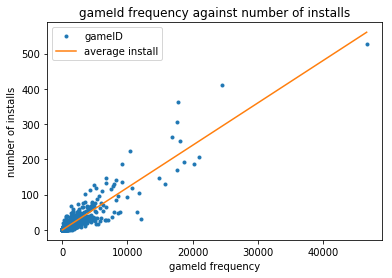

In [15]:
# compute sourceGameId frequencies
gameId_counts = tr_data_m['sourceGameId'].value_counts()
#find the number of installs for each gameId
install_1_frame = tr_data_m[tr_data_m['install'] == 1]
install_per_gameId = np.zeros(gameId_counts.shape[0])
for i in range(gameId_counts.shape[0]):  
    install_per_gameId[i] = sum(install_1_frame['sourceGameId'] == gameId_counts.index[i])

# plot gameId frequencies against number of installs
plt.figure()
plt.plot(gameId_counts,install_per_gameId,'.', label='gameID')
plt.plot([0,max(gameId_counts)],[0,max(gameId_counts)*(Y.sum()/Y.shape[0])], label='average install')
plt.legend()
plt.title("gameId frequency against number of installs")
plt.xlabel("gameId frequency")
plt.ylabel("number of installs")

plt.show()

* Clear linear correlation. Let's use the frequency (similar to 'campaignId') as the new feature and remove the old feature (again we are losing information but this is just a quick hack).

In [26]:
# first convert the gameId_counts to a dict
gameId_dict = gameId_counts.to_dict()

gameId_freq = np.zeros(tr_data_m.shape[0])
for i in range(tr_data_m.shape[0]):
    gameId_freq[i] = gameId_dict[tr_data_m['sourceGameId'][i]]

# add the new feature to the data frame
tr_data_m.insert(1, 'gameId_freq', gameId_freq)

# remove 'sourceGameId' column
tr_data_m = tr_data_m.drop(columns="sourceGameId")

ValueError: cannot insert gameId_freq, already exists

### *country*: 
* The country of the user (total 220 counteries).
* This feature can also help us to convert the time zones to local time (see explanations above).
* There are 101 nulls in this column (only one of them has install event). We drop the corresponding rows.

101
0


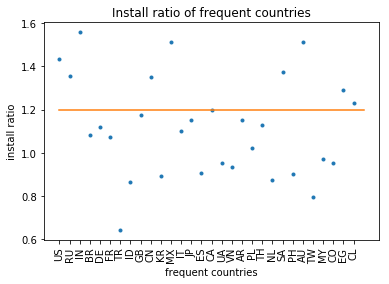

In [17]:
# drop all the nulls (they are only from from 'country' feature) the dataset.
print(tr_data_m['country'].isnull().sum())
tr_data_m.dropna(axis=0, how='any',inplace = True)
print(tr_data_m['country'].isnull().sum())
tr_data_m.reset_index(inplace=True)

# compute country frequencies
country_counts = tr_data_m['country'].value_counts()
#find the number of installs for each country
install_1_frame = tr_data_m[tr_data_m['install'] == 1]
install_per_country = np.zeros(country_counts.shape[0])
for i in range(country_counts.shape[0]):  
    install_per_country[i] = sum(install_1_frame['country'] == country_counts.index[i])

# visualize the install ratio for the most popular countries
install_per_country_ratio = install_per_country/country_counts
plt.plot(install_per_country_ratio[:30]*100,'.')
plt.plot([0,30],[100*Y.sum()/Y.shape[0],100*Y.sum()/Y.shape[0]], label='average install')
plt.xticks(rotation=90)
plt.title("Install ratio of frequent countries")
plt.xlabel("frequent countries")
plt.ylabel("install ratio")
plt.show()

#print(country_counts)
#print(install_per_country)
#print(install_per_country_ratio)    

* I will use the ratio of installs of each country as a new feature value. This to some extent justifiable as it encapsulates the prior knowledge we have about each country. At the same time it is a bit dangerous since we use the training data label information here. The following code box creates this new feature and removes the old one.

In [18]:
# first convert the install_per_country_ratio to a dict
country_dict = install_per_country_ratio.to_dict()
country_freq = np.zeros(tr_data_m.shape[0])
for i in range(tr_data_m.shape[0]):
    country_freq[i] = country_dict[tr_data_m['country'][i]]

# add the new feature to the data frame
tr_data_m.insert(1, 'country_ratio', country_freq)

# remove 'sourceGameId' column
tr_data_m = tr_data_m.drop(columns="country")

### *startCount*, *viewCount*, *clickCount*, *installCount*, *startCount1d*, and *startCount7d* : 
* **startCount**: how many times the user has ever started a campaign ever
* **viewCount**: how many times the user has ever viewed a campaign ever
* **clickCount**: how many times the user has ever clicked a campaign ever
* **installCount**: how many times the user has installed games from this network ever
* **startCount1d**: how many times user has started (any) campaigns within the last 24h
* **startCount7d**: how many times user has started (any) campaigns within the last 7 days
* These seems to be in a a good format. Let's keep them that way.


### connectionType : 
* Internet connection type (three types: wifi, cellular, none)
* The following code block creates two new features ('wifi' and 'cellular') and removes 'connectionType'.

In [19]:
print(tr_data_m['connectionType'].value_counts())

tr_data_m['wifi'] = tr_data_m['connectionType'] == 'wifi' 
tr_data_m['wifi'] = tr_data_m['wifi'].astype(np.int64)

tr_data_m['cellular'] = tr_data_m['connectionType'] == 'cellular' 
tr_data_m['cellular'] = tr_data_m['cellular'].astype(np.int64)

# remove 'connectionType' column
tr_data_m = tr_data_m.drop(columns="connectionType")

wifi        1497694
cellular     691313
none          17882
Name: connectionType, dtype: int64


###  deviceType:              
* Device model (total of 22476 models)
* Would be interesting to see if there is a different install behaviour between people with more high-tech devices or people with tablets, or different brands (Iphone vs. Samsung). The following code block looks at the install ratio of most popular devices. 
* Due to my time constrains, I will remove this column for now (may get back to this later).

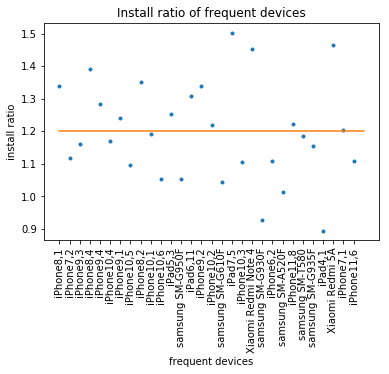

In [20]:
# compute device frequencies
device_counts = tr_data_m['deviceType'].value_counts()
#find the number of installs for each device
install_1_frame = tr_data_m[tr_data_m['install'] == 1]
install_per_device = np.zeros(device_counts.shape[0])
for i in range(device_counts.shape[0]):  
    install_per_device[i] = sum(install_1_frame['deviceType'] == device_counts.index[i])

# visualize the install ratio for the most popular device types
install_per_device_ratio = install_per_device/device_counts
plt.plot(install_per_device_ratio[:30]*100,'.')
plt.plot([0,30],[100*Y.sum()/Y.shape[0],100*Y.sum()/Y.shape[0]], label='average install')
plt.title("Install ratio of frequent devices")
plt.xticks(rotation=90)
plt.xlabel("frequent devices")
plt.ylabel("install ratio")
plt.show()

# remove 'deviceType' column
tr_data_m = tr_data_m.drop(columns="deviceType")

Now let's look how the data looks like after the feature modifications.

In [27]:
#tr_data_m = tr_data_m.drop(columns="index")
with pd.option_context('display.max_rows', 5, 'display.max_columns', None, 'display.width', 100):
    print(tr_data_m.head())
tr_data_m

   country_ratio  campain_freq  gameId_freq  softwareVersion_num  platform  startCount  viewCount  \
0       0.014333          58.0         58.0                 11.0         1          25         24   
1       0.014333          58.0         58.0                 12.0         1          10          9   
2       0.014333          58.0         58.0                 12.0         1          27         26   
3       0.014333          58.0         58.0                 12.0         1          15         14   
4       0.014333          58.0         58.0                 12.0         1          20         18   

   clickCount  installCount  startCount1d  startCount7d  install  epoch_diff  wifi  cellular  
0           0             2             1             8        0        1591     0         1  
1           2             0             1             4        0        2663     0         1  
2           0             0             1             2        0        2941     0         1  
3           2

,country_ratio,campain_freq,gameId_freq,softwareVersion_num,platform,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,install,epoch_diff,wifi,cellular
0,0.014333,58.0,58.0,11.0,1,25,24,0,2,1,8,0,1591,0,1
1,0.014333,58.0,58.0,12.0,1,10,9,2,0,1,4,0,2663,0,1
2,0.014333,58.0,58.0,12.0,1,27,26,0,0,1,2,0,2941,0,1
3,0.014333,58.0,58.0,12.0,1,15,14,2,0,3,14,0,1152,1,0
4,0.014333,58.0,58.0,12.0,1,20,18,0,0,13,18,0,0,0,1
5,0.014333,58.0,58.0,12.0,1,26,4,1,0,7,20,0,41,1,0
6,0.014333,58.0,58.0,12.0,1,38,35,0,0,9,34,0,3,1,0
7,0.014333,58.0,58.0,12.0,1,53,52,1,0,2,53,0,16,1,0
8,0.014333,58.0,58.0,12.0,1,114,110,0,0,5,11,0,1,1,0
9,0.014333,58.0,58.0,11.0,1,47,46,0,0,2,17,0,1,0,1


## The Method

<a id='TL;DR'></a>
<div class=" alert alert-warning">
    <b>tl;dr.</b> 

  <li> Dimensionality reduction </li>
  <li> Error function (confusion matrix), ROC</li>
  <li> Cross validation?</li>
  <li> Logistic regression and random forest</li>

</div>
 